In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')

from utils.data_extraction import load_data
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final, generateFeatures_final
from utils.preprocessing_features_and_labels import extract_labels, align_features_and_labels, preProcessing

### Load data etc

In [6]:
# print(os.listdir())
try:
    path = 'a:/taqhdf5'  #'a:/taqhdf5'
    os.listdir(path)
except:
    path = 't:/taqhdf5'  #'a:/taqhdf5'
    os.listdir(path)    
# allFiles = os.listdir(path)
# print(len(allFiles), allFiles[:5], allFiles[-5:])
# print(allFiles[-10:])

#dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,32)]).astype(int)
dates = np.array(['20200401','20200402','20200403','20200406','20200407']).astype(int)

# Provide a list of tickers of interest
tickers = ['GOOG']#'MSFT'

# Do we need data on trades, quotes or both?
dataNeeded = 'trades' # 'trades', 'quotes' or 'both'

# run load_data()
if dataNeeded == 'trades':
    tradeData = load_data(dates, tickers, dataNeeded, path, verbose)
elif dataNeeded == 'quotes':
    quoteData = load_data(dates, tickers, dataNeeded, path, verbose)
elif dataNeeded == 'both':
    tradeData, quoteData = load_data(dates, tickers, dataNeeded, path, verbose)

['.ipynb_checkpoints', 'Old Versions', 'preprocessing.ipynb', 'testing_and_comparing_candlesticks.ipynb', 'testing_features.ipynb', 'testing_preprocessing_features_and_labels.ipynb']
8521 ['taq_19930315.h5', 'taq_19930104.h5', 'taq_19930317.h5', 'taq_19930105.h5', 'taq_19930316.h5'] ['taqquote_20200529.h5', 'taqtrade_20200601.h5', 'taqtrade_20200602.h5', 'taqtrade_20200603.h5', 'taqtrade_20200605.h5']
['taqquote_20200521.h5', 'taqquote_20200522.h5', 'taqquote_20200526.h5', 'taqquote_20200527.h5', 'taqquote_20200528.h5', 'taqquote_20200529.h5', 'taqtrade_20200601.h5', 'taqtrade_20200602.h5', 'taqtrade_20200603.h5', 'taqtrade_20200605.h5']
##### Date range #####

Date, Min: 20200401
Date, Max: 20200407

##### Data Extraction begins #####

trade data is being extracted..

### Trade Data ###

The raw H5 trade file contains:  ['TradeIndex', 'Trades'] 

Ticker Information:  (b'GOOG            ', 26900500, 71427) 

Sneak peak of the data

            utcsec ex  cond  volume    price TradeStop

In [5]:
tradeData['Date'].unique()

array(['20200401', '20200402', '20200403'], dtype=object)

In [8]:
#cleanedData = HFDataCleaning(['P1','p2','t1','p3'],tradeData,'trade',['q'])


DATA_SAMPLE = 'full' # or 'stable'

if DATA_SAMPLE == 'stable':
    # P1 is used for keeping data within [9.5, 16]
    cleanedData = HFDataCleaning(['P1','p2','t1','p3'],tradeData,'trade',['q'])
elif DATA_SAMPLE == 'full':
    # P1_2 is used for keeping data within [9, 16.5]
    cleanedData = HFDataCleaning(['P1_2','p2', 't1', 'p3'],tradeData,'trade',['q'])

### Original

In [9]:
candles = candleCreateNP_vect_final(cleanedData
                         ,1)

# candles_test = createCandles_test(cleanedData
#                                      ,1)

candles

array([[1122.26, 1127.22, 1119.51, 1126.12],
       [1127.57, 1128.  , 1120.  , 1126.92],
       [1127.19, 1127.4 , 1124.02, 1125.44],
       ...,
       [1190.75, 1190.75, 1187.54, 1189.64],
       [1189.38, 1189.97, 1185.97, 1188.13],
       [1188.22, 1190.52, 1185.  , 1185.96]])

In [10]:
cleanedData.columns

Index(['utcsec', 'ex', 'cond', 'volume', 'price', 'TradeStopStockIndicator',
       'corr', 'TradeSequenceNumber', 'TradeID', 'SourceOfTrade',
       'TradeReportingFacility', 'ParticipantTime', 'TRFTime', 'TTE', 'Date',
       'Timestamp', 'TSRemainder', 'Hour', 'Minute', 'Ticker', 'hour_min_col',
       'time_group'],
      dtype='object')

In [12]:
cleanedData[['cond','utcsec']].groupby('cond').count()

,utcsec
cond,
@,5624
@ I,44139
@ M,5
@ Q,5
@ T,14
@ TI,950
@6 X,5
@F,5857
@F I,57359


# Implementing technical features

A library: https://technical-analysis-library-in-python.readthedocs.io/en/latest/

### Features used in the literature:

* Stochastic K - Implemented
* Stochastic D - Implemented
* Slow Stochastic D - Implemented
* Momentum - Same as difference
* ROC - Implemented
* Williams % R - Implemented
* A/D Oscillator
* Disparity 5 - Implemented
* Disparity 10 - Implemented
* Price Oscillator - (detrended) - Implemented
* Commodity Channel Index - Implemented
* RSI - Impliemented

Formulas: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=876544

* Moving Average - Implemented
* Bias
* Exponential Moving Average - Implemented
* Difference - Same af Momentum
* True Range - (Average) - Implemented
* 

Formulas: https://www.sciencedirect.com/science/article/pii/S0957417407001819?via%3Dihub

#### Other Technical Features
* Moving Average Convergence Divergence (MACD) - Implemented

**Non-classical technical features**

* Bid/Ask prices of top of book
* Spread and mid price based on top og book
* Price derivatives

Formulas: https://www.tandfonline.com/doi/full/10.1080/14697688.2015.1032546?instName=UCL+%28University+College+London%29

In [13]:
n_feature_lags = 0
features = generateFeatures_final(data = candles, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'stok',
                                                    'stod',
                                                    'sstod',
                                                    'wilr',
                                                    'roc',
                                                    'rsi',
                                                    'atr',
                                                    'cci',
                                                    'dpo',
                                                    'sma',
                                                    'ema',
                                                    'macd',
                                                    'dis5',
                                                    'dis10',
                                                   ], 
                                   feature_lags = n_feature_lags) # 0 for no lags, 1 for 1 lag (returns both raw & first lag)
features 

,open,high,low,close,stok,stod,sstod,wilr,roc,rsi,atr,cci,dpo,sma,ema,macd,macd_diff,macd_signal,dis5,dis10
0,1122.26,1127.22,1119.51,1126.12,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1127.57,1128.00,1120.00,1126.92,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1127.19,1127.40,1124.02,1125.44,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1125.01,1125.19,1122.97,1123.00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1123.67,1123.68,1120.01,1121.21,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.704056,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945,1187.75,1191.43,1186.00,1191.11,27.741935,16.524030,62.502916,-72.258065,-0.621579,42.688771,4.349284,-129.305421,2.4205,1196.495833,1194.175301,-1.243443,-1.325122,0.081679,100.045188,99.616874
1946,1191.50,1192.56,1187.93,1190.29,23.963134,21.305684,56.862674,-76.036866,-0.743823,41.540560,4.369335,-107.118223,5.2445,1195.752500,1193.577563,-1.461275,-1.234363,-0.226911,100.025210,99.634206
1947,1190.75,1190.75,1187.54,1189.64,20.967742,24.224270,51.325174,-79.032258,-1.014287,40.608153,4.286525,-110.395712,4.2780,1194.736667,1192.971784,-1.667140,-1.152183,-0.514957,100.022365,99.677667
1948,1189.38,1189.97,1185.97,1188.13,14.009217,19.646697,45.197275,-85.990783,-1.038647,38.449081,4.266059,-113.951905,5.4205,1193.697500,1192.226894,-1.929887,-1.131944,-0.797943,99.894735,99.676757


# Labels (drafts)

In [14]:
n_classes = 5
# load from imported extract_labels()
labels = extract_labels(data = candles, classes = n_classes, group_style = 'equal')
labels

(array([3., 0., 0., ..., 1., 0., 0.]),
 array([ 0.07104039, -0.13133142, -0.21680409, ..., -0.05460854,
        -0.12692916, -0.18263995]),
 [[-1.1398207787255532,
   -0.0892060660124927,
   -0.028417945474212836,
   0.025918865589780182,
   0.08663947149922802],
  [-0.08931068390333197,
   -0.028512621290011086,
   0.025832256989288815,
   0.08660508083140339,
   3.39927860968412]])

# Align features and labels

In [15]:
# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y = align_features_and_labels(candles = candles, 
                                 prediction_horizon = 1, 
                                 features = features, 
                                 n_feature_lags = n_feature_lags, 
                                 n_classes = n_classes, # 5,
                                 safe_burn_in = False, 
                                 data_sample = 'full')

In [16]:
X.shape, y.shape

((1916, 20), (1916,))

## Let's investigate the features a little bit

In [17]:
X.describe()

,open,high,low,close,stok,stod,sstod,wilr,roc,rsi,atr,cci,dpo,sma,ema,macd,macd_diff,macd_signal,dis5,dis10
count,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1.916000e+03,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000
mean,1137.425942,1138.266234,1136.567427,1137.412054,51.255928,5.125577e+01,51.209770,-48.744072,0.042563,50.556969,1.831428,1.465737,-0.057807,1137.199586,1137.197311,0.271755,0.002387,0.269368,100.006725,100.015103
std,39.516677,39.542972,39.475986,39.522262,31.448441,2.911558e+01,22.806948,31.448441,0.513448,11.538853,0.815162,109.101667,2.286705,39.358686,39.313818,1.984924,0.565208,1.883727,0.168130,0.254115
min,1080.010000,1080.800000,1079.780000,1079.880000,0.000000,1.219765e-13,6.090941,-100.000000,-1.310800,21.325832,0.904106,-352.687011,-21.749000,1081.999167,1082.265928,-4.349475,-2.095162,-3.687709,99.314629,99.088681
25%,1106.332500,1107.295000,1105.417500,1106.245000,22.022556,2.372086e+01,31.381202,-77.977444,-0.225600,42.788931,1.340724,-82.979232,-1.046000,1106.452708,1106.530391,-0.805565,-0.242057,-0.755588,99.925091,99.887156
50%,1118.575000,1119.705000,1117.710000,1118.705000,52.371032,5.365452e+01,52.204613,-47.628968,0.007886,50.549928,1.581289,6.594926,0.032250,1118.408333,1118.576434,0.074435,-0.016456,0.111945,100.003359,100.002007
75%,1171.717500,1172.402500,1171.232500,1171.825000,80.391193,7.754071e+01,70.408745,-19.608807,0.219786,58.495508,2.045794,88.120819,1.048750,1171.788958,1171.639049,0.937067,0.220772,0.853428,100.071076,100.111183
max,1224.440000,1225.400000,1220.800000,1223.770000,100.000000,1.000000e+02,95.563197,-0.000000,4.277231,87.081995,6.136863,357.802882,17.013500,1217.176667,1216.072154,13.591786,4.681950,12.163957,102.684524,103.053383


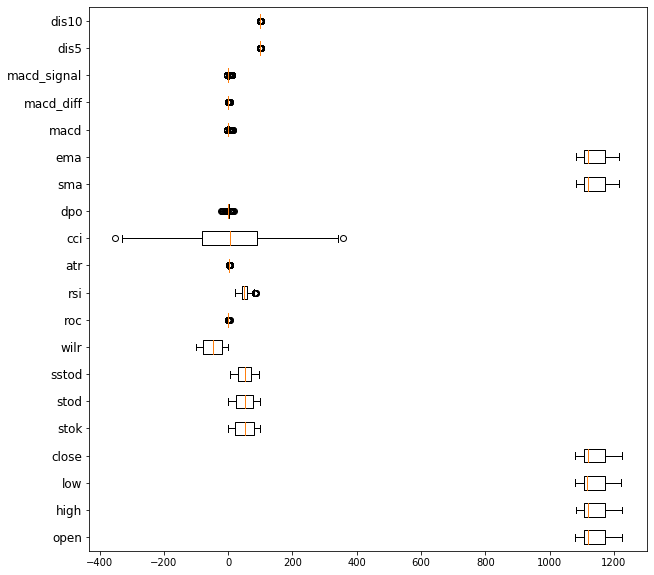

In [18]:
plt.figure(figsize=(10,10))
plt.boxplot(X.values,vert=False)
plt.yticks(np.arange(1,X.shape[1]+1),
           X.columns,fontsize=12)
plt.show()

## Standardization, Normalization (MinMax), Norm-Scaling, Quantile and Power Transformation

**Inspiration:**

* [ScikitLearn Overview](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)
* [A Note on Feature Scaling and Normalization](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html)

In [19]:
# Setting up the Scalers!
mm_scaler = MinMaxScaler()
scaler = StandardScaler()
norm_scaler = Normalizer()
pt = PowerTransformer()
ptNst = PowerTransformer(standardize=False)
qtUni = QuantileTransformer(n_quantiles=100)
qtGau = QuantileTransformer(n_quantiles=100,output_distribution='normal')

For now, we remove features if they are easily scaled down to a desireable range, thereby focusing on the rest.
Features are listed below, as good down-scaling procedures are identified. 

Parentheses indicates that the scaling procedure could work but it is not ideal.

**Open**: Std, Power (Std.), (MinMax) <br>
**High**: Std, Power (Std.), (MinMax)<br>
**Low**: Std, Power (Std.), (MinMax)<br>
**Close**: Std, Power (Std.), (MinMax)<br>
**Stok**: Std, Power (Std.), (MinMax), (Norm)<br>
**Stod**: Std, Power (Std.), (MinMax), (Norm)<br>
**SStod**: Std, Power (Std.), (MinMax), (Norm)<br>
**Wilr**: Std, Power (Std.), (MinMax), (Norm)<br>
**ema**: Std, Power (Std.), (MinMax)<br>
**sma**: Std, Power (Std.), (MinMax)<br>
**Dis5**: Substract 100 <br>
**Dis10**: Substract 100 <br>
**Macd_diff**: baseline <br>
**Roc**: baseline demeaned<br>
**Atr**: baseline demeaned <br>
**Rsi**: Std., Quantile Transformation (Gaussian), Power (Std.) <br>
**Cci**: Quantile Transformation (Gaussian), (Power (Std.)) <br>
**Dpo**: Quantile Transformation (Gaussian),  (Norm) <br>
**Macd**: Quantile Transformation (Gaussian) <br>
**Macd_Signal**: Quantile Transformation (Gaussian) <br>


In [141]:
tempX = X.drop(columns=['open',
                        'high',
                        'low',
                        'close',
                        'stok',
                        'stod',
                        'sstod',
                        'wilr',
                        'sma',
                        'ema',
                        'dis5',
                        'dis10',
                        'macd_diff',
                        'roc',
                        'atr',
                        'rsi']).copy(deep=True)
# tempX = X.copy(deep=True)

In [128]:
tempX.describe()

,cci,dpo,macd,macd_signal
count,1916.000000,1916.000000,1916.000000,1916.000000
mean,1.465737,-0.057807,0.271755,0.269368
std,109.101667,2.286705,1.984924,1.883727
min,-352.687011,-21.749000,-4.349475,-3.687709
25%,-82.979232,-1.046000,-0.805565,-0.755588
50%,6.594926,0.032250,0.074435,0.111945
75%,88.120819,1.048750,0.937067,0.853428
max,357.802882,17.013500,13.591786,12.163957


## Baseline

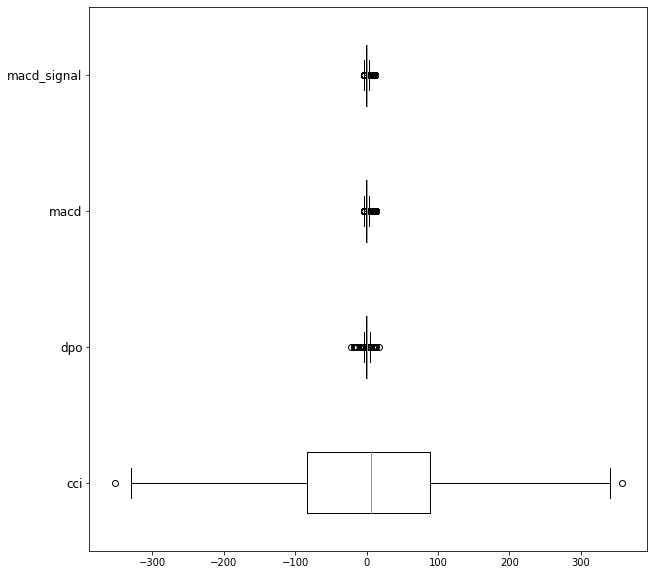

In [142]:
# tempX = tempX.drop(columns=['cci'])
plt.figure(figsize=(10,10))
plt.boxplot(tempX.values,vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

In [130]:
val = tempX.roc
print('Min: ',round(val.min(),3),
      '\nMax: ',round(val.max(),3),
      '\nMedian: ',round(val.median(),3),
      '\nMean: ',round(val.mean(),3))

AttributeError: 'DataFrame' object has no attribute 'roc'

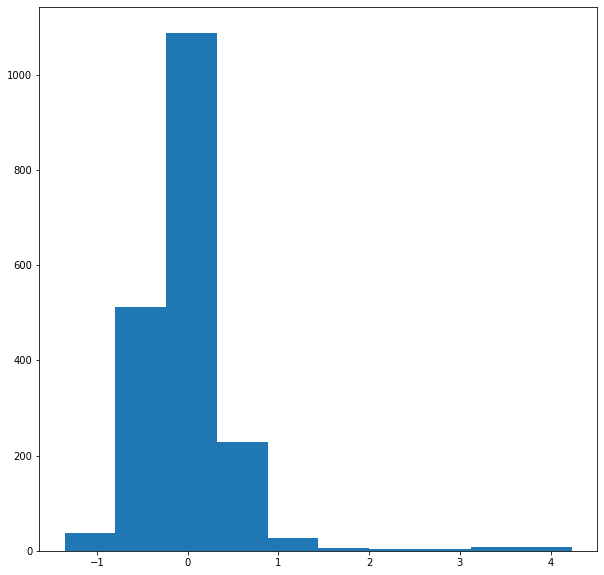

In [131]:
plt.figure(figsize=(10,10))
plt.hist((val-val.mean()))#-tempX.atr.mean()
plt.show()

## Standardization

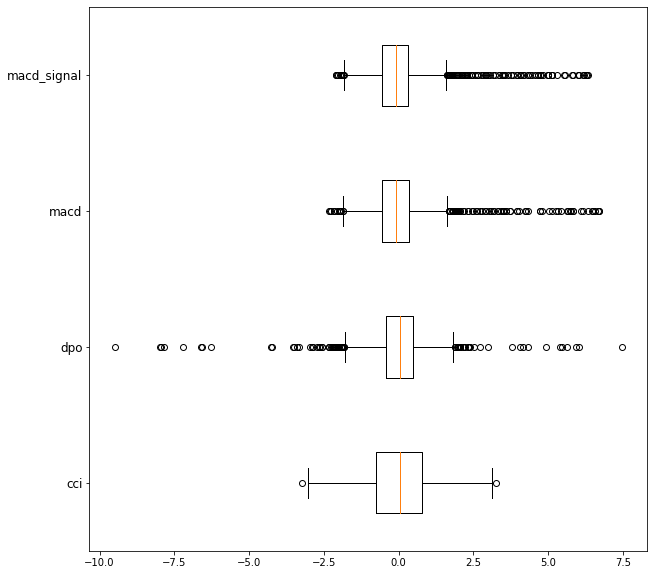

In [132]:
plt.figure(figsize=(10,10))
plt.boxplot(scaler.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Normalization

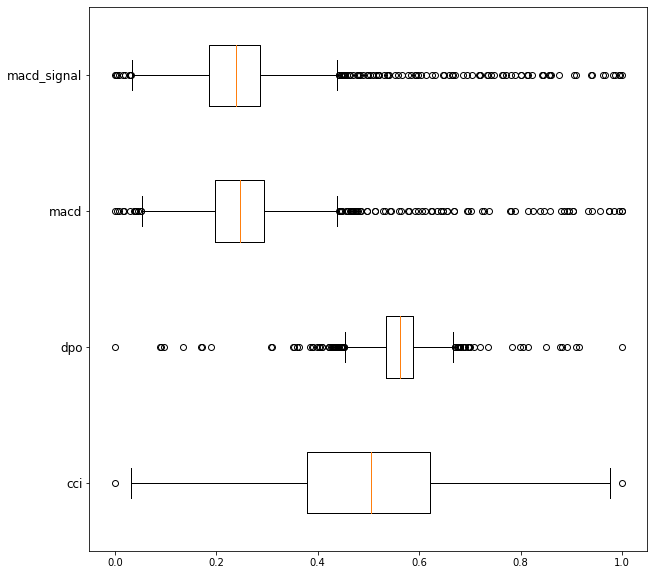

In [133]:
plt.figure(figsize=(10,10))
plt.boxplot(mm_scaler.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Norm-Scaling

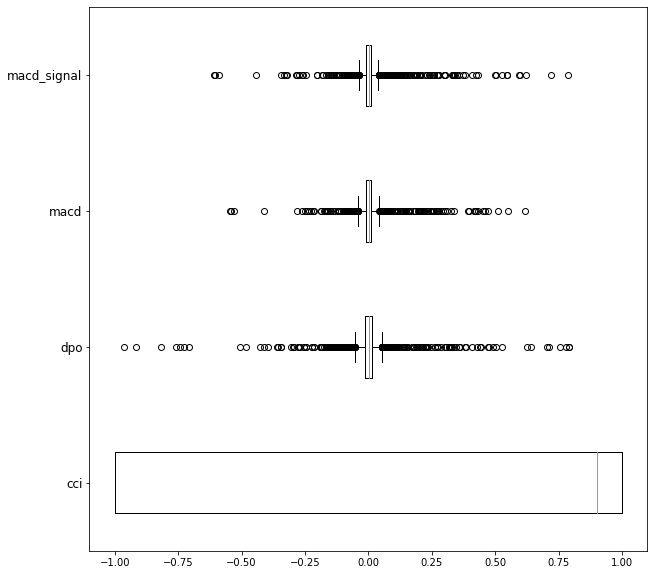

In [134]:
plt.figure(figsize=(10,10))
plt.boxplot(norm_scaler.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Quantile Transformation (Uniform)

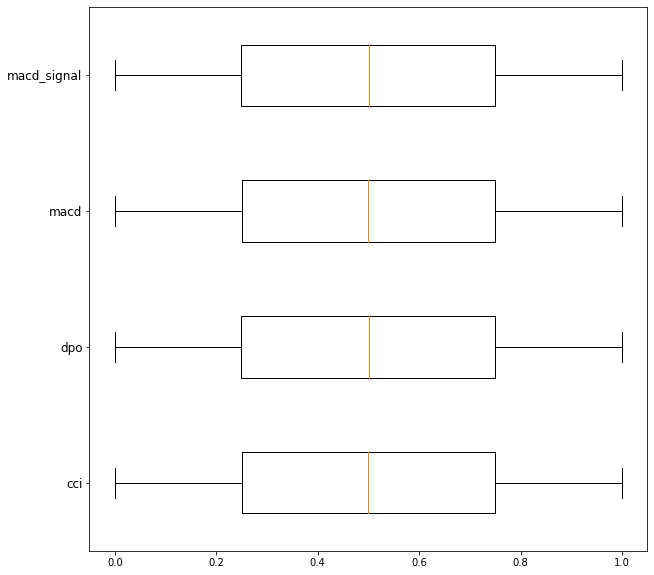

In [135]:
plt.figure(figsize=(10,10))
plt.boxplot(qtUni.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Quantile Transform (Gaussian)

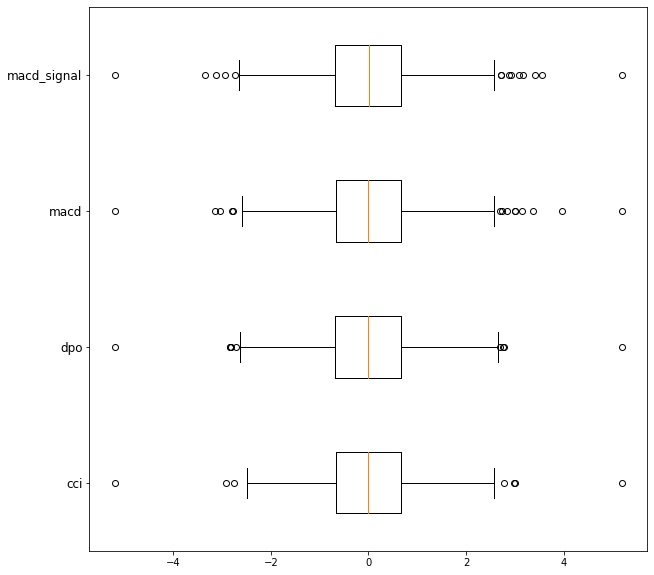

In [136]:
plt.figure(figsize=(10,10))
plt.boxplot(qtGau.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Power Transformation (Standardized)

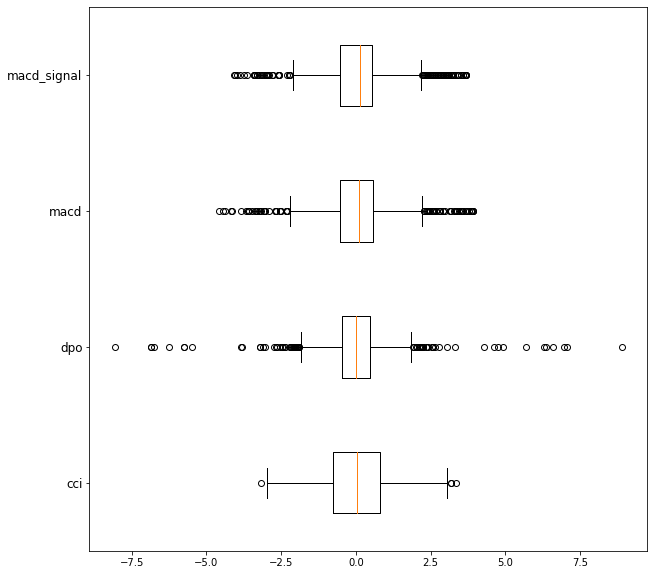

In [137]:
plt.figure(figsize=(10,10))
plt.boxplot(pt.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

## Power (Not Standardized)

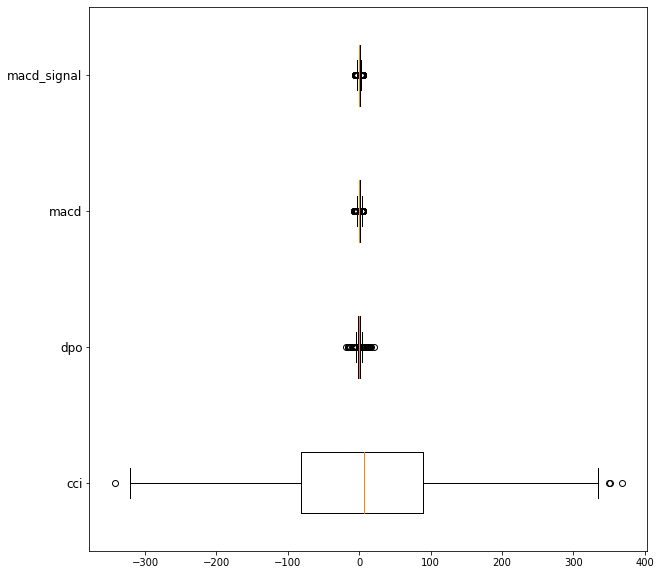

In [138]:
# tempX = tempX.drop(columns=['cci'])
plt.figure(figsize=(10,10))
plt.boxplot(ptNst.fit_transform(tempX),vert=False)
plt.yticks(np.arange(1,tempX.shape[1]+1),
           tempX.columns,fontsize=12)
plt.show()

In [139]:
stop

NameError: name 'stop' is not defined

This below list was generated above, now we try to implement the output.

Parentheses indicates that the scaling procedure could work but it is not ideal.

**Open**: Std, Power (Std.), (MinMax) <br>
**High**: Std, Power (Std.), (MinMax)<br>
**Low**: Std, Power (Std.), (MinMax)<br>
**Close**: Std, Power (Std.), (MinMax)<br>
**Stok**: Std, Power (Std.), (MinMax), (Norm)<br>
**Stod**: Std, Power (Std.), (MinMax), (Norm)<br>
**SStod**: Std, Power (Std.), (MinMax), (Norm)<br>
**Wilr**: Std, Power (Std.), (MinMax), (Norm)<br>
**ema**: Std, Power (Std.), (MinMax)<br>
**sma**: Std, Power (Std.), (MinMax)<br>
**Dis5**: Substract 100 <br>
**Dis10**: Substract 100 <br>
**Macd_diff**: actual values <br>
**Roc**: actual values demeaned<br>
**Atr**: actual values demeaned <br>
**Rsi**: Std., Quantile Transformation (Gaussian), Power (Std.) <br>
**Cci**: Quantile Transformation (Gaussian), (Power (Std.)) <br>
**Dpo**: Quantile Transformation (Gaussian),  (Norm) <br>
**Macd**: Quantile Transformation (Gaussian) <br>
**Macd_Signal**: Quantile Transformation (Gaussian) <br>

In [187]:
featurePreProcessing = {'open':'std',
                        'close':'std',
                        'high':'std',
                        'low':'std',
                        'stok':'std',
                        'stod':'std',
                        'sstod':'std',
                        'wilr':'std',
                        'ema':'std',
                        'sma':'std',
                        'dis5':'sub',
                        'dis10':'sub',
                        'macd_diff':'act',
                        'roc':'actde',
                        'atr':'actde',
                        'rsi':'std',
                        'cci':'quantgau',
                        'dpo':'quantgau',
                        'macd':'quantgau',
                        'macd_signal':'quantgau'}

subBy = 100

key = []
item = []

for k,i in featurePreProcessing.items():
    key.append(k)
    item.append(i)

# Numping
key = np.array(key)
item = np.array(item)
    
preproX = pd.DataFrame()

for ele in np.unique(item):
    if verbose:
        print('Pre-Processing Procedure: ',ele)
    if ele.lower() == 'act':
        if verbose:
            print('Columns Processed:',key[item==ele],'\n')
        
        # Adding the raw feature to the new frame
        preproX[key[item==ele]] = X[key[item==ele]]

    elif ele.lower() == 'actde':
        print('Columns Processed:',key[item==ele],'\n')
        
        # Adding the demeaned features to the new frame
#         print(X[key[item==ele]].head())
#         print(X[key[item==ele]].mean())
#         print((X[key[item==ele]]-X[key[item==ele]].mean()).head())
        preproX[key[item==ele]] = X[key[item==ele]]-X[key[item==ele]].mean()
        
    elif ele.lower() == 'quantgau':
        print('Columns Processed:',key[item==ele],'\n')
        
        # Adding the transformed features to the new frame
        preproX[key[item==ele]] = pd.DataFrame(qtGau.fit_transform(X[key[item==ele]].values))
        
    elif ele.lower() == 'std':
        print('Columns Processed:',key[item==ele],'\n')
        
        # Adding the transformed features to the new frame
        preproX[key[item==ele]] = pd.DataFrame(scaler.fit_transform(X[key[item==ele]].values))
        
    elif ele.lower() == 'sub':
        print('Columns Processed:',key[item==ele],'\n')
        
        # Adding the transformed features to the new frame
        preproX[key[item==ele]] = X[key[item==ele]]-subBy
        
    elif ele.lower() == 'pow':
        print('Columns Processed:',key[item==ele],'\n')
        
        # Adding the transformed features to the new frame
        preproX[key[item==ele]] = pd.DataFrame(pt.fit_transform(X[key[item==ele]].values))
        
    elif ele.lower() == 'minmax':
        print('Columns Processed:',key[item==ele],'\n')
        
        # Adding the transformed features to the new frame
        preproX[key[item==ele]] = pd.DataFrame(mm_scaler.fit_transform(X[key[item==ele]].values))
        
    elif ele.lower() == 'norm':
        print('Columns Processed:',key[item==ele],'\n')
        
        # Adding the transformed features to the new frame
        preproX[key[item==ele]] = pd.DataFrame(norm_scaler.fit_transform(X[key[item==ele]].values))

Pre-Processing Procedure:  act
Columns Processed: ['macd_diff'] 

Pre-Processing Procedure:  actde
Columns Processed: ['roc' 'atr'] 

Pre-Processing Procedure:  quantgau
Columns Processed: ['cci' 'dpo' 'macd' 'macd_signal'] 

Pre-Processing Procedure:  std
Columns Processed: ['open' 'close' 'high' 'low' 'stok' 'stod' 'sstod' 'wilr' 'ema' 'sma'
 'rsi'] 

Pre-Processing Procedure:  sub
Columns Processed: ['dis5' 'dis10'] 



In [188]:
preproX

,macd_diff,roc,atr,cci,dpo,macd,macd_signal,open,close,high,low,stok,stod,sstod,wilr,ema,sma,rsi,dis5,dis10
0,-0.058970,-0.298770,1.048176,-0.544818,-0.691927,-1.749602,-1.772677,-0.549176,-0.508506,-0.517705,-0.535337,-0.328704,-0.976202,-1.629099,-0.328704,-0.503618,-0.504351,-0.677158,0.123483,0.031245
1,-0.061346,-0.248360,1.045347,-0.691563,1.633794,-1.768802,-1.807920,-0.512979,-0.559376,-0.508851,-0.538631,-1.194975,-0.900719,-1.592299,-1.194975,-0.511812,-0.509222,-1.108115,-0.052335,-0.116424
2,0.028554,-0.445800,0.979864,-0.744582,0.648300,-1.652588,-1.791239,-0.550695,-0.531537,-0.548565,-0.556114,-0.712188,-0.804999,-1.557873,-0.712188,-0.514440,-0.518795,-0.762092,0.038890,0.001433
3,0.327867,0.050383,1.067628,0.297427,0.348429,-1.262269,-1.665851,-0.508423,-0.441691,-0.450671,-0.487194,0.832445,-0.386938,-1.474765,0.832445,-0.502767,-0.516592,0.158201,0.267868,0.306753
4,0.645633,0.264078,1.050553,0.989325,0.237743,-0.889015,-1.442764,-0.457798,-0.390061,-0.411463,-0.436517,1.550372,0.601501,-1.297630,1.550372,-0.484905,-0.509328,0.576685,0.339832,0.459409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911,-1.443775,-1.062580,2.434724,-1.724024,1.010418,-0.846521,0.309693,1.280150,1.273740,1.322546,1.229488,-1.241847,-1.231991,0.764198,-1.241847,1.463870,1.522732,-1.267910,-0.262498,-0.753950
1912,-1.325122,-0.664143,2.517856,-1.158911,1.491322,-1.040915,-0.021637,1.273822,1.359031,1.344806,1.252546,-0.747895,-1.193204,0.495292,-0.747895,1.449690,1.506954,-0.682065,0.045188,-0.383126
1913,-1.234363,-0.786386,2.537907,-0.900880,2.333275,-1.217192,-0.261189,1.368743,1.338277,1.373390,1.301449,-0.868085,-1.028931,0.247924,-0.868085,1.434482,1.488063,-0.781600,0.025210,-0.365794
1914,-1.152183,-1.056850,2.455097,-0.933770,2.167462,-1.322783,-0.473540,1.349759,1.321827,1.327605,1.291567,-0.963358,-0.928663,0.005061,-0.963358,1.419069,1.462247,-0.862427,0.022365,-0.322333


## Baseline

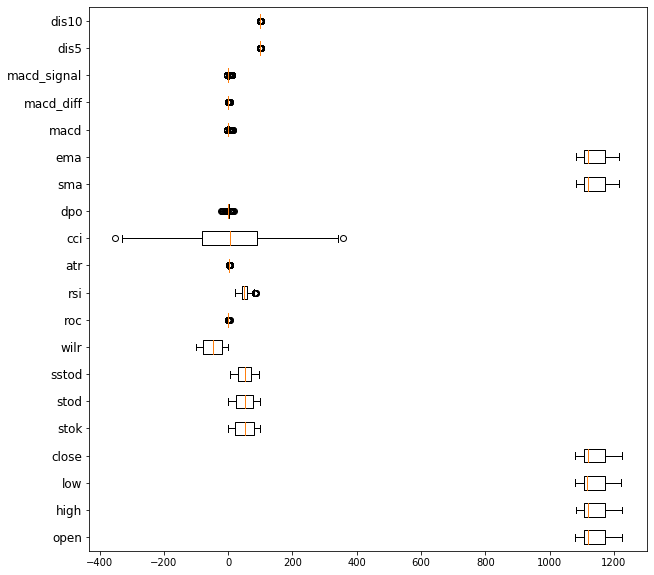

In [189]:
plt.figure(figsize=(10,10))
plt.boxplot(X.values,vert=False)
plt.yticks(np.arange(1,X.shape[1]+1),
           X.columns,fontsize=12)
plt.show()

## PreProcessed

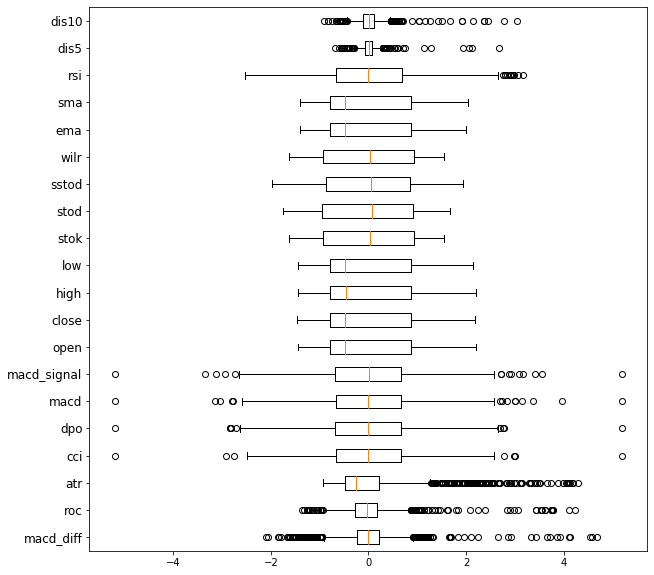

In [190]:
# tempX = tempX.drop(columns=['cci'])
plt.figure(figsize=(10,10))
plt.boxplot(preproX.values,vert=False)
plt.yticks(np.arange(1,preproX.shape[1]+1),
           preproX.columns,fontsize=12)
plt.show()

In [196]:
def preProcessing(ppDict,subBy,verbose=False):
    
    # Creating empty lists to hold the content of our pre-processing dictonary
    key = []
    item = []
    
    # Extracting the items of the pre-processing dictonary
    for k,i in ppDict.items():
        key.append(k)
        item.append(i)

    # Numping
    key = np.array(key)
    item = np.array(item)
    
    # Creating an empty dataframe to store the pre-processed data.
    preproX = pd.DataFrame()
    
    # Pre-processing the data according to the desired ways.
    for ele in np.unique(item):
        if verbose:
            print('Pre-Processing Procedure: ',ele)
        
        # Return the actual values
        if ele.lower() == 'act':
            if verbose:
                print('Columns Processed:',key[item==ele],'\n')

            # Adding the raw feature to the new frame
            preproX[key[item==ele]] = X[key[item==ele]]
        
        # Return the actual values demeaned
        elif ele.lower() == 'actde':
            if verbose:
                print('Columns Processed:',key[item==ele],'\n')

            # Adding the demeaned features to the new frame
    #         print(X[key[item==ele]].head())
    #         print(X[key[item==ele]].mean())
    #         print((X[key[item==ele]]-X[key[item==ele]].mean()).head())
            preproX[key[item==ele]] = X[key[item==ele]]-X[key[item==ele]].mean()
        
        # Return the features quantiale transformed (gaussian)
        elif ele.lower() == 'quantgau':
            if verbose:
                print('Columns Processed:',key[item==ele],'\n')

            # Adding the transformed features to the new frame
            preproX[key[item==ele]] = pd.DataFrame(qtGau.fit_transform(X[key[item==ele]].values))
        
        # Return the features standardized
        elif ele.lower() == 'std':
            if verbose:
                print('Columns Processed:',key[item==ele],'\n')

            # Adding the transformed features to the new frame
            preproX[key[item==ele]] = pd.DataFrame(scaler.fit_transform(X[key[item==ele]].values))
        
        # Return the features substracted a certain amount
        elif ele.lower() == 'sub':
            if verbose:
                print('Columns Processed:',key[item==ele],'\n')

            # Adding the transformed features to the new frame
            preproX[key[item==ele]] = X[key[item==ele]]-subBy
        
        # Return the features power transformed (standardized)
        elif ele.lower() == 'pow':
            if verbose:
                print('Columns Processed:',key[item==ele],'\n')

            # Adding the transformed features to the new frame
            preproX[key[item==ele]] = pd.DataFrame(pt.fit_transform(X[key[item==ele]].values))
        
        # Return the features min-max-normalised
        elif ele.lower() == 'minmax':
            if verbose:
                print('Columns Processed:',key[item==ele],'\n')

            # Adding the transformed features to the new frame
            preproX[key[item==ele]] = pd.DataFrame(mm_scaler.fit_transform(X[key[item==ele]].values))
        
        # Return the features norm scale
        elif ele.lower() == 'norm':
            if verbose:
                print('Columns Processed:',key[item==ele],'\n')

            # Adding the transformed features to the new frame
            preproX[key[item==ele]] = pd.DataFrame(norm_scaler.fit_transform(X[key[item==ele]].values))
            
    return preproX

In [197]:
test = preProcessing(featurePreProcessing,100)
test.head()

,macd_diff,roc,atr,cci,dpo,macd,macd_signal,open,close,high,low,stok,stod,sstod,wilr,ema,sma,rsi,dis5,dis10
0,-0.058970,-0.298770,1.048176,-0.544818,-0.691927,-1.749602,-1.772677,-0.549176,-0.508506,-0.517705,-0.535337,-0.328704,-0.976202,-1.629099,-0.328704,-0.503618,-0.504351,-0.677158,0.123483,0.031245
1,-0.061346,-0.248360,1.045347,-0.691563,1.633794,-1.768802,-1.807920,-0.512979,-0.559376,-0.508851,-0.538631,-1.194975,-0.900719,-1.592299,-1.194975,-0.511812,-0.509222,-1.108115,-0.052335,-0.116424
2,0.028554,-0.445800,0.979864,-0.744582,0.648300,-1.652588,-1.791239,-0.550695,-0.531537,-0.548565,-0.556114,-0.712188,-0.804999,-1.557873,-0.712188,-0.514440,-0.518795,-0.762092,0.038890,0.001433
3,0.327867,0.050383,1.067628,0.297427,0.348429,-1.262269,-1.665851,-0.508423,-0.441691,-0.450671,-0.487194,0.832445,-0.386938,-1.474765,0.832445,-0.502767,-0.516592,0.158201,0.267868,0.306753
4,0.645633,0.264078,1.050553,0.989325,0.237743,-0.889015,-1.442764,-0.457798,-0.390061,-0.411463,-0.436517,1.550372,0.601501,-1.297630,1.550372,-0.484905,-0.509328,0.576685,0.339832,0.459409


In [198]:
all(test == preproX)

True

## Split data into train and test set

In [20]:
#X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((684, 12), (77, 12), (684,), (77,))

In [21]:
X

,stok_lag0,rsi_lag0,stok_lag1,rsi_lag1,stok_lag2,rsi_lag2,stok_lag3,rsi_lag3,stok_lag4,rsi_lag4,stok_lag5,rsi_lag5
0,34.650670,38.190482,34.509527,38.127207,30.557516,36.435332,53.539873,42.747368,66.831334,47.132255,75.088920,50.096776
1,30.400000,40.039506,34.650670,38.190482,34.509527,38.127207,30.557516,36.435332,53.539873,42.747368,66.831334,47.132255
2,31.028037,44.271410,30.400000,40.039506,34.650670,38.190482,34.509527,38.127207,30.557516,36.435332,53.539873,42.747368
3,24.208411,42.486262,31.028037,44.271410,30.400000,40.039506,34.650670,38.190482,34.509527,38.127207,30.557516,36.435332
4,13.751313,37.927234,24.208411,42.486262,31.028037,44.271410,30.400000,40.039506,34.650670,38.190482,34.509527,38.127207
...,...,...,...,...,...,...,...,...,...,...,...,...
756,92.141063,62.398921,70.450281,49.769063,58.917197,54.074441,63.421292,55.306438,88.989991,62.855193,35.571260,46.562037
757,73.084973,53.047195,92.141063,62.398921,70.450281,49.769063,58.917197,54.074441,63.421292,55.306438,88.989991,62.855193
758,90.962746,59.221774,73.084973,53.047195,92.141063,62.398921,70.450281,49.769063,58.917197,54.074441,63.421292,55.306438
759,88.781917,58.216044,90.962746,59.221774,73.084973,53.047195,92.141063,62.398921,70.450281,49.769063,58.917197,54.074441
